In [261]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from UtilityGraph import *
from Defence import *
from Corruption import *
from UtilityMLP import *
import random
from collections import deque
from scipy.stats import *
import copy
import seaborn as sns
from Test import *
import math
import itertools
import pandas as pd
import plotly.express as px
from ipywidgets import interact, IntSlider


# %matplotlib notebook
%matplotlib widget


In [262]:
Seed = 2001  # for reproducibility
random.seed(Seed)
np.random.seed(Seed) 
torch.manual_seed(Seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(Seed)
    torch.cuda.manual_seed_all(Seed)


In [263]:
# Graph
required_probability=0.999
num_nodes, G,A,pos,r_c=build_random_graph(40,required_probability,fix_num_nodes=True) #  ,r_fix=999 or 0.3
print("num_nodes:",num_nodes)

percentageCorrupt = 1/num_nodes   #Percentage of corrupt clients




var = 30                  # Standard deviation for Gaussian noise
mean = 1                    # Mean for Gaussian noise
Target = np.random.randint(1, num_nodes) # Target client for copycat attack
scale = 1
typeAttack = 0              # 0: No attack, 1: Gaussian noise, 2: Copycat attack, 3: Gaussian addative noise attack, 4: LIE attack

corrupt = True              #If True, corrupt clients are included
CorruptClients = CorruptGeneration(percentageCorrupt, corrupt, num_nodes) #Selection of Corrupt Clients
CorruptClients = np.array(CorruptClients, dtype=int)

lying_nodes = np.where(CorruptClients == 1)[0]
true_nodes = [i for i in range(num_nodes) if i not in lying_nodes]

test1 = 0
# Data
Data = np.zeros([num_nodes,1])
RealMean = 25
RealVar = 30
for i in range(num_nodes):
    Data[i] = np.random.normal(RealMean, np.sqrt(RealVar))
    test1 += G.degree(i)

print(test1/num_nodes)

Control = Data.copy()

neighbors_dict = {}
for ln in lying_nodes:
    neighbors_dict[ln] = list(G.neighbors(ln))

print("Neighbors of lying nodes:", neighbors_dict)



num_nodes: 40
IteNumber of Corrupt nodesration 1, Corrupt nodes: [6]
8.75
Neighbors of lying nodes: {6: [2, 3, 4, 8, 9, 10, 14, 15, 19, 26, 27, 28, 29, 37]}


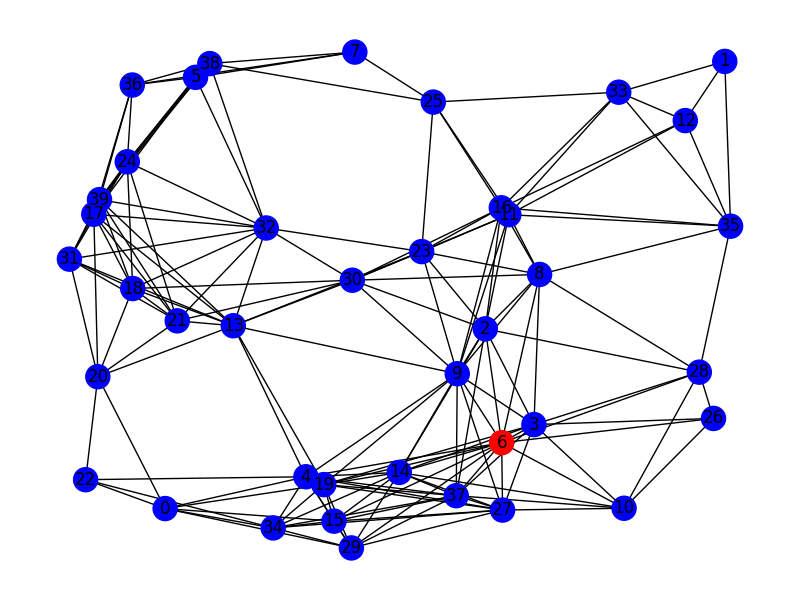

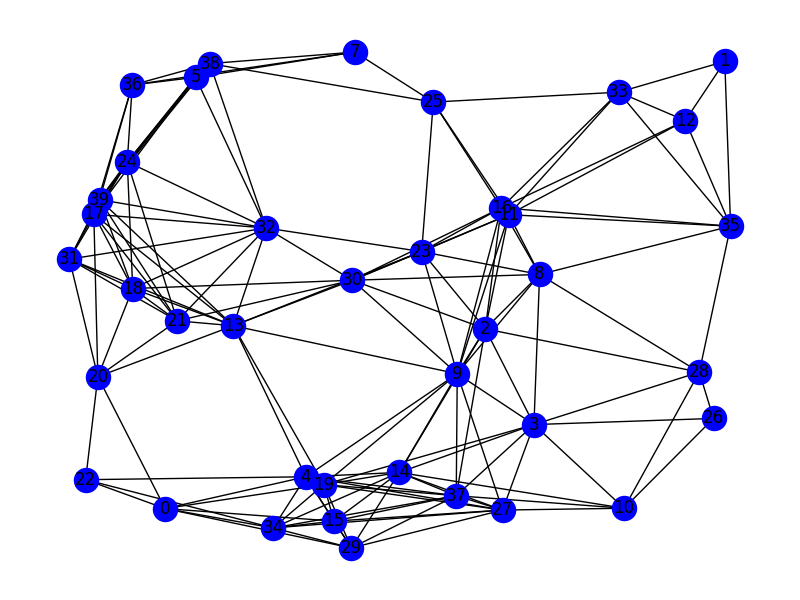

Are the honest‐only nodes still forming a connected subgraph? True


In [264]:
plt.figure(figsize=(8,6))
color_map = []
for node in range(num_nodes):
    if node in lying_nodes:
        color_map.append('red')   # corrupt
    else:
        color_map.append('blue')  # honest

nx.draw(G, pos, with_labels=True, node_color=color_map)
plt.title("Graph with Lying (Red) and Honest (Blue) Nodes")
plt.show()

remaining_nodes = [n for n in G.nodes() if n not in lying_nodes]
G_sub = G.subgraph(remaining_nodes)

pos_sub = {n: pos[n] for n in remaining_nodes}

plt.figure(figsize=(8,6))
nx.draw(G_sub, pos_sub, with_labels=True, node_color="blue")
plt.title("Subgraph After Removing Corrupt Nodes\n(Honest Nodes Only)")

plt.show()

still_connected = nx.is_connected(G_sub)
print("Are the honest‐only nodes still forming a connected subgraph?",
      still_connected)




In [265]:
def iterative_thresholding(values, initial_threshold, tol=1e-3):
    """
    Performs iterative (two-group) thresholding on 'values' array.

    Steps:
    1) Split values into G1 (those > T_old) and G2 (≤ T_old).
    2) m1 = mean(G1), m2 = mean(G2)
    3) T_new = (m1 + m2)/2
    4) Repeat until |T_new - T_old| < tol or we reach max_iter.

    :param values: 1D np.array of floats
    :param initial_threshold: float, starting threshold
    :param tol: float, stopping tolerance
    :param max_iter: int, maximum iteration count
    :return: float, the final threshold
    """
    T_old = initial_threshold

    G1 = values[values > T_old]
    G2 = values[values <= T_old]

    if G1.size == 0 or G2.size == 0:
        T_new = T_old
    else:
        m1 = np.mean(G1)
        m2 = np.mean(G2)
        T_new = 0.5 * (m1 + m2)
    
    # if abs(T_new - T_old) < tol:
    #     break
    T_old = T_new

    return T_old


In [266]:
# def check_U_values(theta_now, theta_prev, i, G, c, num_nodes, count, window_size, personal_S_history):
#     """
#     Computes u_{i,j}(t) and U_{i,j}(t) for a *single* iteration t, 
#     given the current and previous theta = calc_dual arrays.
    
#     :param theta_now:   2D array, theta_{k,l}(t+1)
#     :param theta_prev:  2D array, theta_{k,l}(t)
#     :param i:           Node index for which we compute these values
#     :param G:           Graph
#     :param mu:          1/eta, or the 'stepsize' used in eq. (14b)
#     :param num_nodes:   Number of nodes
#     :return: A 1D array U_vals, where U_vals[j] = U_{i,j}(t).
#              (We only fill j if j is in neighbors(i); otherwise 0.)
#     """
#     u = np.zeros(num_nodes)  # will hold u_{i,j}(t) for j in neighbors(i)
#     U = np.zeros(num_nodes)  # will hold U_{i,j}(t) likewise

#     if i not in personal_S_history:
#         personal_S_history[i] = []
#     # # Compute mu based on geometric decay
#     # mu = (gamma**(count) * delta_0)
#     # mu = 1
#     # mu = c**(count/4)
#     # 1) Compute all u_{i,j}(t) for j in N_i

#     neighbor_diffs = []
#     for j in G.neighbors(i):
#         diff_val = abs(theta_now[j][i] - theta_prev[j][i])
#         neighbor_diffs.append(diff_val)
    
#     # Use the median of neighbor differences as the current scale.
#     if neighbor_diffs:
#         S_current = np.median(neighbor_diffs)
#     else:
#         S_current = 1e-14  
    
#     personal_S_history[i].append(S_current)

#     if len(personal_S_history[i]) >= window_size:
#         s_t = np.median(personal_S_history[i][-window_size:])
#     else:
#         s_t = S_current  

#     mu = s_t
#     # mu = c*np.log(count+1)
#     # mu = c
#     for j in G.neighbors(i):
#         # eq. (14b): u_{i,j}(t) = 1/eta(t) [ theta_{i,j}(t+1) - theta_{i,j}(t) ]
#         # We'll treat 'mu' as 1/eta with 'count' as the (t).
#             u[j] = (theta_now[j][i] - theta_prev[j][i]) * 1/(mu)
    
#     # 2) For each j, we need the median of { u_{i,l}(t) : l in N_i \ j }.
#     #    Then U_{i,j}(t) = || u_{i,j}(t) - median(...) ||_∞.
#     #    In 1D, the L∞-norm is just absolute value.
#     for j in G.neighbors(i):
#         # collect neighbors except j
#         neighbor_u_vals = []
#         for l in G.neighbors(i):
#             if l != j:
#                 neighbor_u_vals.append(u[l])
#         median_val = np.median(neighbor_u_vals) if neighbor_u_vals else 0.0
#         # U[j] =  np.log(abs(u[j] - median_val))
#         U[j] =  abs(abs(u[j]) - abs(median_val))
    
#     return U, u

In [267]:
def check_U_values(theta_now, theta_prev, i, G, c, num_nodes, count, window_size, personal_S_history):
    """
    Computes u_{i,j}(t) and U_{i,j}(t) for a single iteration t by using the change
    in the median of raw differences (from node i's neighbors) as a stepsize for normalization.
    
    For node i:
      1. For each neighbor j, compute the raw difference:
            raw_diff[j] = theta_now[j][i] - theta_prev[j][i]
      2. Compute the median (of the absolute values) of these raw differences: 
            M_current = median(|raw_diff[j]| for j in N_i)
      3. Store M_current in personal_S_history[i].
      4. If there is a previous median M_previous, set the stepsize = max(|M_current - M_previous|, ε).
         If no previous value exists, use M_current (or a fallback ε) as the stepsize.
      5. Normalize each raw difference using this stepsize.
      6. Finally, for each neighbor j, compute U[j] as the absolute difference between |u[j]| and
         the median of the |u[l]| for all other neighbors l ≠ j.
    
    :param theta_now:   2D array, theta_{k,l}(t+1)
    :param theta_prev:  2D array, theta_{k,l}(t)
    :param i:           Node index for which we compute these values.
    :param G:           Graph (neighbors of i are obtained via G.neighbors(i)).
    :param c:           A parameter (unused in this version, but kept for compatibility).
    :param num_nodes:   Total number of nodes.
    :param count:       Current iteration count.
    :param window_size: Unused in this version (kept for compatibility).
    :param personal_S_history: A dictionary mapping node index to a list of past median values.
    
    :return: A tuple (U, u), where:
             - u is a 1D array with normalized differences u_{i,j}(t) for each neighbor j,
             - U is a 1D array with U[j] = | |u[j]| - median({|u[l]| for l in N_i, l ≠ j}) |.
    """
    epsilon = 1e-14  # Minimal stepsize to avoid division by zero.
    
    stepsize = 0

    # Initialize output arrays.
    u = np.zeros(num_nodes)
    U = np.zeros(num_nodes)
    
    # Collect neighbor indices for node i.
    neighbor_indices = list(G.neighbors(i))
    
    # 1. Compute raw differences for each neighbor j of node i.
    raw_diffs = []
    for j in neighbor_indices:
        raw_diff = theta_now[j][i] - theta_prev[j][i]
        raw_diffs.append(raw_diff)
    
    # 2. Compute the current median of the absolute raw differences.
    # (This median represents the typical magnitude of the changes received from neighbors.)
    if raw_diffs:
        M_current = np.median(np.abs(raw_diffs))
    else:
        M_current = 1e-14  # For count = 0
    
    # 3. Ensure that there is an entry in personal_S_history for node i.
    if i not in personal_S_history:
        personal_S_history[i] = []
    
    # 4. Determine the stepsize from the difference between the current median and the previous one.
    if personal_S_history[i]:
        M_previous = personal_S_history[i][-1]
        stepsize = abs(M_current + M_previous)/2
        if stepsize == 0:
            stepsize = epsilon
    
    # Update the persistent history with the current median.
    personal_S_history[i].append(M_current)
    
    # 5. Compute the normalized differences using the computed stepsize.
    # That is, for each neighbor j, set:
    #   u[j] = (theta_now[j][i] - theta_prev[j][i]) / stepsize
    for idx, j in enumerate(neighbor_indices):
        raw_diff = theta_now[j][i] - theta_prev[j][i]
        # u[j] = raw_diff / c
        u[j] = raw_diff / stepsize
    # 6. Compute the robust deviation U for each neighbor.
    # For each neighbor j, compute the median of the absolute normalized differences from the other neighbors.
    for j in neighbor_indices:
        other_u_vals = []
        for l in neighbor_indices:
            if l != j:
                other_u_vals.append(u[l])
        if other_u_vals:
            median_other = np.median(np.abs(other_u_vals))
        else:
            median_other = 0.0
        # U[j] = abs(abs(u[j]) - abs(median_other))
        U[j] = abs(abs(u[j]) - abs(median_other))
    
    return U, u


In [268]:
def PDMM(
    Data, G, avg_temp, tolerance, c, max_iters, Control,
    averaging, Timer, K_decision, rejection_threshold, perm_threshold, when, corruption_start, lying_nodes, window_size, CorruptValue
):
    """
    PDMM with attacker detection/avoidance, using EXACT eq. (14a), (14b), (13).

    :param Data:                (num_nodes x 1) array of node data
    :param G:                   networkx Graph
    :param avg_temp:            target average for convergence check
    :param tolerance:           stopping threshold for ||x - avg_temp||
    :param c:                   penalty parameter in PDMM
    :param max_iters:           maximum number of iterations
    :param Control:             not used currently
    :param averaging:           alpha in z-update
    :param Timer:               number of iterations = ΔT
    :param K_decision:          longer window for repeated rejections
    :param rejection_threshold: δ_u in eq. (13)
    :param mu:                  1/eta(t) factor for eq. (14b)
    
    :return:
        Error, count, dual_history, x_history, z_history,
        dual_calc_history, x_calc_history
    """

    # Reproducibility seeds
    Seed = 2001
    random.seed(Seed)
    np.random.seed(Seed)
    torch.manual_seed(Seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(Seed)
        torch.cuda.manual_seed_all(Seed)

    num_nodes = G.number_of_nodes()
    x = np.zeros([num_nodes, 1])
    converged = False
    Error = np.array([])

    # Incidence
    A_ij = calc_incidence_nested(G)

    # Get a consistent ordering of the nodes.
    nodes = sorted(G.nodes())
    num_nodes = len(nodes)

    # Create an empty NumPy array for the incidence matrix.
    A = np.zeros((num_nodes, num_nodes))

    # Fill the NumPy array with the entries from the dictionary.
    # If there is no edge from i to j, we leave it as 0.
    for i_idx, i in enumerate(nodes):
        for j_idx, j in enumerate(nodes):
            A[i_idx, j_idx] = A_ij.get(i, {}).get(j, 0)

    D = np.diag(np.sum(A, axis=1))  # Diagonal matrix with node degrees on the diagonal

    # Compute the Laplacian matrix L
    L = D - A
    # Compute the eigenvalues of the Laplacian
    eigenvalues = np.linalg.eigvals(L)
    # Sort eigenvalues
    sorted_eigenvalues = np.sort(eigenvalues)[::-1]

    # Fiedler value is the second smallest eigenvalue
    fiedler_value = sorted_eigenvalues[1]
    # Find the largest eigenvalue
    largest_eigenvalue = np.max(sorted_eigenvalues)

    print("Largest eigenvalue of the Laplacian:", largest_eigenvalue)
    print("Fiedler eigenvalue of the Laplacian:", fiedler_value)


    personal_S_history = {}

    # z, y, dual, calc_dual, ...
    z = np.zeros((num_nodes, num_nodes))
    # z = np.random.normal(loc=0, scale=10**6, size=(num_nodes, num_nodes))
    # z = z * (A != 0) 
    y = np.zeros((num_nodes, num_nodes))
    y_transmit = np.zeros((num_nodes, num_nodes))
    dual = np.zeros((num_nodes, num_nodes))
    calc_dual = np.zeros((num_nodes, num_nodes))
    calc_x = np.zeros((num_nodes, 1))
    temp_y = np.zeros((num_nodes, num_nodes))

    sum_check = np.zeros((num_nodes, num_nodes))
    delta_u = np.zeros([num_nodes, 1])

    mask = np.ones((num_nodes, num_nodes), dtype=bool)
    reject_count = np.zeros((num_nodes, num_nodes), dtype=int)

    dual_history = []
    y_history = []
    x_history = []
    z_history = []
    dual_calc_history = []
    x_calc_history = []

    dual_calc_history.append(calc_dual.copy())


    Thresh_Error = []

    rejected_nodes = set()  # Keeps track of nodes deemed "rejected"
    k = 0
    thresholds = np.zeros(num_nodes, dtype=float)  # each node i has thresholds[i]
    count_reject = 0
    Delta_history = []
    count = 0
    Track = 0

    even_counter = 0

    window_size = 5

    while (not converged) and (count < max_iters):
        if count == corruption_start:
            for node in lying_nodes:
                Data[node] = CorruptValue

        # print("                      The count for this iteration is           ", count)

        # --------------------
        # 1) Update x
        # --------------------
        x_new = np.zeros_like(x)
        for i in range(num_nodes):
            corrupt_neighbors = sum(1 for j in G.neighbors(i) if j in rejected_nodes)  # Count rejected neighbors
            numerator_i = Data[i].copy()
            for j in G.neighbors(i):
                if mask[i][j]:
                    numerator_i += -A_ij[i][j] * z[i][j]
                        # Adjust denominator: exclude rejected nodes from degree count
            effective_degree = G.degree(i) - corrupt_neighbors
            x_new[i] = numerator_i / (1 + c * effective_degree)
        x = x_new
        x_history.append(x.copy())

        # --------------------
        # 2) Update dual
        # --------------------
        for i in range(num_nodes):
            for j in G.neighbors(i):
                # if mask[i][j]:
                dual[i][j] = z[i][j] + c * (x[i] * A_ij[i][j])
        dual_history.append(dual.copy())

        # --------------------
        # 3) Update y
        # --------------------
        for i in range(num_nodes):
            for j in G.neighbors(i):
                # if mask[i][j]:
                temp_y[i][j] = y[i][j]
                y[i][j] = 2 * dual[i][j] - z[i][j]
        if count > 0:
            theta_prev = y_history[-1]  # the last stored calc_dual
        else:
            theta_prev = y.copy()
        theta_now  = y
        
        y_history.append(y.copy())

        # "Transmit" y and compute calc_dual
        for i in range(num_nodes):
            for j in G.neighbors(i):
                calc_dual[j][i] = (y[j][i] + temp_y[i][j]) / 2

        # -------------------------------------------------
        # Compute u_{i,j}(t) and U_{i,j}(t), then accumulate
        # -------------------------------------------------
        if count % 2 == 0 and count >= when:
            sum_u = 0
            for i in range(num_nodes):
                # Compare current calc_dual (theta_now) vs. previous dual_calc_history[count] (theta_prev)
                # theta_now  = calc_dual
                # theta_prev = dual_calc_history[-1]  # the last stored calc_dual
                U_vals, u_val = check_U_values(theta_now, theta_prev, i, G, c, num_nodes, count, window_size, personal_S_history)
                sum_u += np.linalg.norm(u_val)

                # Accumulate these into sum_check so that after Timer steps
                # we can form ∆U_{i,j}.
                for j in G.neighbors(i):
                    sum_check[i][j] += U_vals[j]
            # Delta_history.append((sum_u).copy())
            even_counter += 1


            if (count) % (Timer) == 0:

                DeltaU = np.zeros((num_nodes, num_nodes))
                count_reject += 1
                # print(f"Entered Timer block. {count_reject} Timer blocks so far.")
                # Now we form ∆U_{i,j} = (2 / Timer)* sum_check[i][j].
                for i in range(num_nodes):
                    if count_reject == 1:
                        thresholds[i] = rejection_threshold * np.sqrt(G.degree(i))
                        # thresholds[i] = rejection_threshold * np.sqrt(G.degree(i)) /(c*np.log(count+1))
                    for j in G.neighbors(i):
                        DeltaU[i][j] = (2.0 / (Timer) ) * sum_check[i][j]  
                        # print(f"Node {i} sees DeltaU_{i},{j}={DeltaU[i][j]:.4f} and  {rejection_threshold}*sqrt(|N_i|). The Difference is {DeltaU[i][j] - rejection_threshold*np.sqrt(G.degree(i)):.4f}")
                        # Compare to δ_u sqrt(|N_i|)
                        # if j == 6:
                        if DeltaU[i][j] > (thresholds[i]):
                            reject_count[i][j] += 1
                            print(f"Node {i} sees DeltaU_{i},{j}={DeltaU[i][j]:.4f} > {thresholds[i]}; incrementing D(i,j), at count {count} for rejection count = {reject_count[i][j]}") 
                    # neighbors_i = list(G.neighbors(i))
                    # DeltaU_list = [DeltaU[i][j] for j in neighbors_i]  # array of neighbor values
                    # DeltaU_array = np.array(DeltaU_list, dtype=float)
                    # thresholds[i] = iterative_thresholding(DeltaU_array, thresholds[i])
                # reset sum_check after each block of length Timer
                sum_check = np.zeros((num_nodes, num_nodes))
                Track += 1
                Delta_history.append(DeltaU.copy())
                # Timer = np.ceil(Timer + c*np.log(count+1))
                # if Timer % 2 != 0:
                #     Timer = Timer + 1

                # Long-term final decision if neighbor is repeatedly rejected
                if Track % K_decision == 0:
                    # print(f"Track was divible by K_decision={K_decision}; checking for permanent rejections.")
                    for i in range(num_nodes):
                        for j in G.neighbors(i):
                            # If more than half of those Timer-block checks were bad => mask out
                            rejection_ratio = reject_count[i][j] / K_decision
                            # if j == 6:
                            #     mask[i][j] = False
                            #     reject_count[i][j] = K_decision
                            #     print(f"Node {i} permanently rejecting node {j} (ratio={rejection_ratio:.2f}), at count {count}.")
                            # #   print("Removed at iteration ", count)
                            #     rejected_nodes.add(j)
                            #     continue 
                            if rejection_ratio > perm_threshold:
                                mask[i][j] = False
                                print(f"Node {i} permanently rejecting node {j} (ratio={rejection_ratio:.2f}), at count {count}.")
                                # print("Removed at iteration ", count)
                                rejected_nodes.add(j)
                            else:
                                mask[i][j] = True
                                if j in rejected_nodes:
                                    rejected_nodes.remove(j)
                    # if 6 in rejected_nodes:
                        # print(f"Node 6 rejected at iteration {count}.")
                            # Optionally reset reject_count if you want a rolling window
                            reject_count[i][j] = 0
                    # for k in rejected_nodes:    
                    #     neighbors_to_remove = list(G.neighbors(k))
                    #     for nbd in neighbors_to_remove:
                    #         G.remove_edge(k, nbd)
        # --------------------
        # 4a) Send y from i to j (i is sender, j is receiver)
        # --------------------
        for i in range(num_nodes):
            for j in G.neighbors(i):
                # Check if i is allowed to send to j
                if not mask[i][j] or not mask[j][i]:
                    y_transmit[i][j] = y_transmit[i][j]  # Block transmission
                else:
                    y_transmit[i][j] = y[i][j]  # Send y[i][j] to j

        # --------------------
        # 4b) Update z at i (i is receiver, j is sender)
        # --------------------
        for i in range(num_nodes):
            for j in G.neighbors(i):
                # Check if i is allowed to receive from j (j sends to i)
                if not mask[j][i] or not mask[j][i]:
                    z[i][j] = (1 - averaging) * z[i][j]  # Block reception
                else:
                    # Update z[i][j] with y sent from j to i
                    z[i][j] = (1 - averaging) * z[i][j] + averaging * y_transmit[j][i]

        dual_calc_history.append(calc_dual.copy())
        x_calc_history.append(calc_x.copy())
        z_history.append(z.copy())
        
        Thresh_norm = thresholds[1]
        Thresh_Error = np.append(Thresh_Error, Thresh_norm)

        # sigma_zeta_inf = np.linalg.norm(-u_val, ord=np.inf)
        dual_honest = []
        dual_corrupt = []

        for i in range(num_nodes):
            for j in G.neighbors(i):
                # if either i or j is in lying_nodes, call that a "corrupt" edge
                if (i in lying_nodes) or (j in lying_nodes):
                    dual_corrupt.append( dual[i][j] )
                else:
                    dual_honest.append( dual[i][j] )

        # # For convergence check
        diff = np.abs(x[true_nodes] - avg_temp)  # Removes unnecessary dimensions
        
        # if rejected_nodes:  
        #     rejected_nodes_array = np.array(list(rejected_nodes), dtype=int)  # Convert to array
        #     diff[rejected_nodes_array] = 0
        # print(f"{diff} diff and {x[true_nodes]} x and {avg_temp} avg_temp")
        norm_diff = np.linalg.norm(diff)
        Error = np.append(Error, norm_diff)

        count += 1
        if norm_diff < tolerance:
            print(f"Iteration {count}, Norm of difference: {norm_diff:.8f} => converged.")
            converged = True
    if rejected_nodes:
        print("Final x =", x.flatten())
        print("Data mean = ", np.mean(Data))
        print("Removed nodes:", rejected_nodes)
        print(Error[-1])
    return (
        Error, Delta_history, y_history, x_history, dual_calc_history, count, z_history, Thresh_Error
)

In [269]:
def ADMM(Data, G, avg_temp, tolerance, rho, max_iters, Control):
    Seed = 2001  # for reproducibility
    random.seed(Seed)
    np.random.seed(Seed) 
    torch.manual_seed(Seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(Seed)
        torch.cuda.manual_seed_all(Seed)

    num_nodes = G.number_of_nodes()
    x = np.zeros((num_nodes,1))
    z = np.zeros((num_nodes, num_nodes))
    y = np.zeros((num_nodes, num_nodes))
    y_history = [] 
    x_history = [] 
    z_history = []
    Error = np.array([])
    count = 0
    converged = False

    while not converged and count < max_iters:
        # Synchronous update for x
        x_new = np.zeros_like(x)
        for i in range(num_nodes):
            neighbors_i = list(G.neighbors(i))
            numerator_i = Data[i].copy()
            for nbr in neighbors_i:
                numerator_i += rho * z[i][nbr] - y[i][nbr]
            x_new[i] = numerator_i / (1 + rho * G.degree(i))
        x = x_new
        x_history.append(x.copy())  # Store dual values for this iteration

        # Synchronous update for z and y
        for i in range(num_nodes):
            for j in G.neighbors(i):
                z_val = 0.5 * (x[i] + x[j])
                z[i][j] = z_val

        z_history.append(z.copy())  # Store dual values for this iteration


        for i in range(num_nodes):
            for j in G.neighbors(i):
                y[i][j] = y[i][j] + rho * (x[i] - z[i][j])


        y_history.append(y.copy())  # Store dual values for this iteration
        
        diff = x - avg_temp
        norm_diff = np.linalg.norm(diff)
        Error = np.append(Error, norm_diff)

        count += 1
        if norm_diff < tolerance:
            print(f'Iteration {count}, Norm of difference: {norm_diff:.8f}')
            converged = True

    print(f"x = {x}")
    return Error, count, y_history, x_history, z_history


In [270]:
import csv
def save_delta_history_to_csv(Delta_history, filename="delta_history.csv"):
    """Save Delta_history to a CSV file."""
    if not Delta_history:
        print("Delta_history is empty. No data to save.")
        return
    
    # Get matrix dimensions from the first entry
    num_nodes = Delta_history[0].shape[0]
    
    # Create headers: "iteration", "node0_node0", "node0_node1", ..., "nodeN_nodeN"
    headers = ["iteration"] + [f"node{i}_node{j}" for i in range(num_nodes) for j in range(num_nodes)]
    
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(headers)  # Write header row
        
        # Write each iteration's data
        for iteration_idx, delta_u in enumerate(Delta_history):
            # Flatten the 2D matrix into a 1D list and prepend the iteration index
            row = [iteration_idx] + delta_u.flatten().tolist()
            writer.writerow(row)
    
    print(f"Saved Delta_history to {filename}")

In [271]:
def main():
    calc_mean = 0
    max_iters=400             #PDMM max iterations
    averaging = 1         #Averaging alpha
    tolerance=-1e-13        #PDMM tolerance
    c=0.5                   #PDMM c

    Import = 0
    window_size = 5


    # nodes_list = nodeSelection(max_iters, num_nodes)
    print(f"Average before corrupt data {np.mean(Data)}")
    honest_nodes = np.where(CorruptClients == 0)[0]  
    avg_temp = np.sum(Data[honest_nodes]) / len(honest_nodes)

    # This checks if lying_nodes is not empty
    # for node in lying_nodes:
    #     Data[node] = 10000
    CorruptValue = 10000

    print(f"average without the corrupt node {avg_temp}")
    Error = []
    Error_A = []
    Thresh_Error = []
    perm_threshold = 0.5    #Threshold for permanent rejection
    when = 0                #When to start the rejection process
    corruption_start = 0    #When to start the corruption process
    if Import == 0:

    # # Timer values (integers > 0)
        # Timer_values = list(range(1, 5))  # 1-20, then larger steps

        # K_decision values (integers > 0)
        # K_decision_values = list(range(1, 5))# 1-15, then larger jumps

        # Rejection thresholds (0.1 to 30 with logarithmic density)
        # rejection_thresholds = np.round(
        #     np.arange(150, 160, 1),  # Start at 0.1, stop before 10.1, step 0.1
        #     0                        # Round to 1 decimal place
        # ).tolist()

        Timer_values = [1]
        
        K_decision_values = [-2]
        
        rejection_thresholds = [10]
        # rejection_thresholds = [19,20,21,22,23,24,25,26,27,28,29,30]

        # rejection_thresholds = np.round(
        #     np.arange(1, 2, 0.1),  # Start at 0.1, stop before 10.1, step 0.1
        #     1                           # Round to 1 decimal place
        # ).tolist()
        # Remove duplicates and sort
        rejection_thresholds = sorted(list(set(rejection_thresholds)))
    
        # Generate all combinations
        param_grid = list(itertools.product(Timer_values, K_decision_values, rejection_thresholds))

    if Import == 1:
        #  Read the CSV file
        df_params = pd.read_csv('converged_params.csv')
        print("Loaded parameters from converged_params.csv")

        #Create a list of tuples directly from the DataFrame
        param_grid = list(zip(df_params['Timer'], df_params['K_decision'], df_params['Threshold']))
        print(f"param_grid (from CSV) = {param_grid}")

    results = []

    for params in param_grid:
        Timer, K_decision, rejection_threshold = params

        try:
            # Run PDMM with current parameters
            Error, Delta_history, y_history, x_history, dual_calc_history, count, z_history, Thresh_Error = PDMM(
                Data, G, avg_temp, tolerance, c, max_iters, Control,
                averaging, Timer, K_decision, rejection_threshold, perm_threshold, when, corruption_start, lying_nodes, window_size, CorruptValue
            )


            # Interactive plot for z and dual variables
            def plot_variables(step):
                plt.figure(figsize=(10, 5))
                
                plt.subplot(1, 3, 1)
                plt.imshow(z_history[step], cmap='viridis', aspect='auto', origin='lower')
                plt.colorbar()
                plt.title('z at step {}'.format(step))
                plt.xlabel('Neighbor Index')
                plt.ylabel('Node Index')

                plt.subplot(1, 3, 2)
                plt.imshow(dual_calc_history[step], cmap='viridis', aspect='auto', origin='lower')
                plt.colorbar()
                plt.title('Dual at step {}'.format(step))
                plt.xlabel('Neighbor Index')
                plt.ylabel('Node Index')
                                
                plt.subplot(1, 3, 3)
                plt.imshow(y_history[step], cmap='viridis', aspect='auto', origin='lower')
                plt.colorbar()
                plt.title('y at step {}'.format(step))
                plt.xlabel('Neighbor Index')
                plt.ylabel('Node Index')
                
                
                plt.tight_layout()
                plt.show()

            interact(plot_variables, step=IntSlider(min=0, max=len(z_history)-1, step=1, value=0));

            l2_norms = []

            # Iterate over each step in z_history
            for step, z in enumerate(y_history):
                # Extract nonzero values from the current z array
                nonzero_values = z[z != 0]  # Filter out zero values 
                
                # Compute the L2 norm of the nonzero values
                l2_norm = np.linalg.norm(nonzero_values)  # L2 norm calculation 
                l2_norms.append(l2_norm)

            # Plot the L2 norms over steps
            plt.figure(figsize=(8, 6))
            plt.plot(range(len(y_history)), l2_norms, marker='o', linestyle='-', color='b')
            plt.yscale('log')
            plt.title('L2 Norm of Nonzero Values Over Steps')
            plt.xlabel('Step')
            plt.ylabel('L2 Norm')
            plt.grid(True)
            plt.show()

            # Initialize a list to store differences between successive iterations
            differences = []

            # Compute the difference between successive iterations
            for i in range(1, len(y_history)):
                diff = np.linalg.norm(y_history[i] - y_history[i - 1])  # L2 norm of the difference
                differences.append(diff)

            # Plot the differences
            plt.figure(figsize=(8, 6))
            plt.plot(range(1, len(y_history)), differences, marker='o', linestyle='-', color='b')
            plt.yscale('log')
            plt.title('Difference Between Successive Iterations')
            plt.xlabel('Iteration')
            plt.ylabel('L2 Norm of Difference')
            plt.grid(True)
            plt.show()
            
            def plot_Delta(step):
                plt.figure(figsize=(10, 5))
                plt.imshow(Delta_history[step], cmap='viridis', aspect='auto', origin='lower')
                plt.colorbar()
                plt.title('Delta at step {}'.format(step))
                plt.xlabel('Neighbor Index')
                plt.ylabel('Node Index')                
                plt.tight_layout()
                plt.show()

            interact(plot_Delta, step=IntSlider(min=0, max=len(Delta_history)-1, step=1, value=0));

            # Plotting the individual node errors over the iterations
            fig, ax = plt.subplots(figsize=(12, 6))

            plt.figure()
            plt.plot(range(len(Thresh_Error)), Thresh_Error, label='PDMM Convergence')
            # plt.yscale('log')
            plt.title('Thresh_Error Convergence Over Iteration Rounds')
            plt.xlabel('Iteration Round')
            plt.ylabel('Norm Error')
            # Standard grid (horizontal and vertical lines)
            plt.grid(True)

            plt.legend()
            plt.show()
            num_nodes = len(Data)

            # Calculate the error for each node over the iterations
            node_errors = np.zeros((len(Error), num_nodes))
            for t in range(len(Error)):
                for i in range(num_nodes):
                    node_errors[t, i] = np.linalg.norm(x_history[t][i] - avg_temp)

            # Plotting the errors for each node
            for i in range(num_nodes):
                ax.plot(node_errors[:, i], label=f'Node {i}')

            ax.set_title('Individual Node Errors over Iterations')
            ax.set_xlabel('Iterations')
            ax.set_yscale('log')
            ax.set_ylabel('L2 Norm of Error')
            ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.0), ncol=1)
            plt.tight_layout()
            plt.show()
            
            plt.figure()
            plt.plot(range(len(Error)), Error, label='PDMM Convergence')
            plt.yscale('log')
            plt.title('Error Convergence Over Iteration Rounds')
            plt.xlabel('Iteration Round')
            plt.ylabel('Norm Error')
            # Standard grid (horizontal and vertical lines)
            plt.grid(True)

            plt.legend()
            plt.show()

            

            # plt.figure(figsize=(10, 4))

            # # Store results
            # results.append({
            #     'Timer': Timer,
            #     'K_decision': K_decision,
            #     'Rejection_Threshold': rejection_threshold,
            #     'Final_Error': Error[-1],
            #     'Converged': len(Error) < max_iters
            # })
            
        except Exception as e:
            print(f"Failed for {params}: {str(e)}")

    # # Convert to DataFrame
    # results_df = pd.DataFrame(results)

    # # Find top 10 performing combinations
    # top_combinations = results_df.sort_values('Final_Error').head(10)
    # print("Best parameter combinations:")
    # print(top_combinations)


    # plt.figure(figsize=(10, 6))
    # sns.scatterplot(
    #     data=results_df,
    #     x='Rejection_Threshold',
    #     y='Final_Error',
    #     hue='Timer',
    #     size='K_decision',
    #     sizes=(40, 200),
    #     palette='viridis'
    # )
    # plt.title('Error vs Parameters')
    # plt.yscale('log')
    # plt.show()

    # fig = px.scatter_3d(
    #     results_df,
    #     x='Timer',
    #     y='K_decision',
    #     z='Rejection_Threshold',
    #     color='Final_Error',
    #     color_continuous_scale='Viridis',
    #     log_z=True
    # )
    # fig.update_layout(title='3D Parameter Space Analysis')
    # fig.show()

    # results_df.to_csv('pdmm_optimization_results_adaptive.csv', index=False)
    # # print(dual_calc_history)


Average before corrupt data 24.880885221911527
average without the corrupt node 24.82560823263965
Largest eigenvalue of the Laplacian: (9.34550448657669+0.25078828365689965j)
Fiedler eigenvalue of the Laplacian: (9.34550448657669-0.25078828365689965j)
Node 1 sees DeltaU_1,12=102.4612 > 17.32050807568877; incrementing D(i,j), at count 2 for rejection count = 1
Node 1 sees DeltaU_1,33=99.0314 > 17.32050807568877; incrementing D(i,j), at count 2 for rejection count = 1
Node 1 sees DeltaU_1,35=201.4925 > 17.32050807568877; incrementing D(i,j), at count 2 for rejection count = 1
Node 9 sees DeltaU_9,6=40.7121 > 37.416573867739416; incrementing D(i,j), at count 2 for rejection count = 1
Node 10 sees DeltaU_10,6=311.3361 > 26.457513110645905; incrementing D(i,j), at count 2 for rejection count = 1
Node 13 sees DeltaU_13,4=238.5635 > 34.64101615137754; incrementing D(i,j), at count 2 for rejection count = 1
Node 13 sees DeltaU_13,9=235.7889 > 34.64101615137754; incrementing D(i,j), at count 2 

C:\Users\za_re\AppData\Local\Temp\ipykernel_23000\3875362925.py:146: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dual[i][j] = z[i][j] + c * (x[i] * A_ij[i][j])
C:\Users\za_re\AppData\Local\Temp\ipykernel_23000\602189526.py:76: RuntimeWarning: invalid value encountered in scalar divide
  u[j] = raw_diff / stepsize


Node 2 sees DeltaU_2,3=41.5394 > 33.166247903553995; incrementing D(i,j), at count 38 for rejection count = 1
Node 2 sees DeltaU_2,3=49.7605 > 33.166247903553995; incrementing D(i,j), at count 40 for rejection count = 1
Node 1 sees DeltaU_1,35=20.4093 > 17.32050807568877; incrementing D(i,j), at count 82 for rejection count = 1
Node 10 sees DeltaU_10,3=30.6949 > 26.457513110645905; incrementing D(i,j), at count 102 for rejection count = 1
Node 10 sees DeltaU_10,3=33.8181 > 26.457513110645905; incrementing D(i,j), at count 142 for rejection count = 1
Node 10 sees DeltaU_10,6=29.1111 > 26.457513110645905; incrementing D(i,j), at count 184 for rejection count = 1
Node 7 sees DeltaU_7,38=24.0000 > 20.0; incrementing D(i,j), at count 198 for rejection count = 1
Node 11 sees DeltaU_11,2=32.0000 > 31.622776601683796; incrementing D(i,j), at count 220 for rejection count = 1
Node 29 sees DeltaU_29,6=51.3333 > 30.0; incrementing D(i,j), at count 232 for rejection count = 1
Node 26 sees DeltaU_2

interactive(children=(IntSlider(value=0, description='step', max=399), Output()), _dom_classes=('widget-intera…

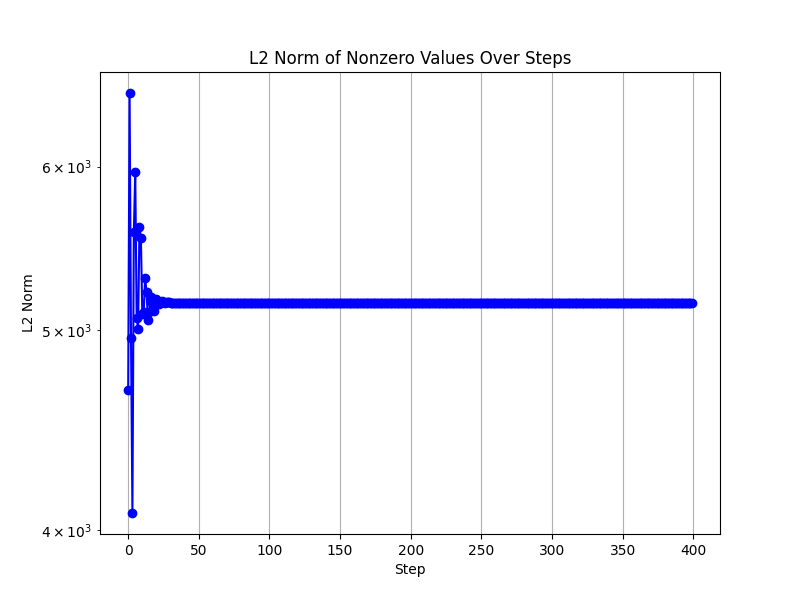

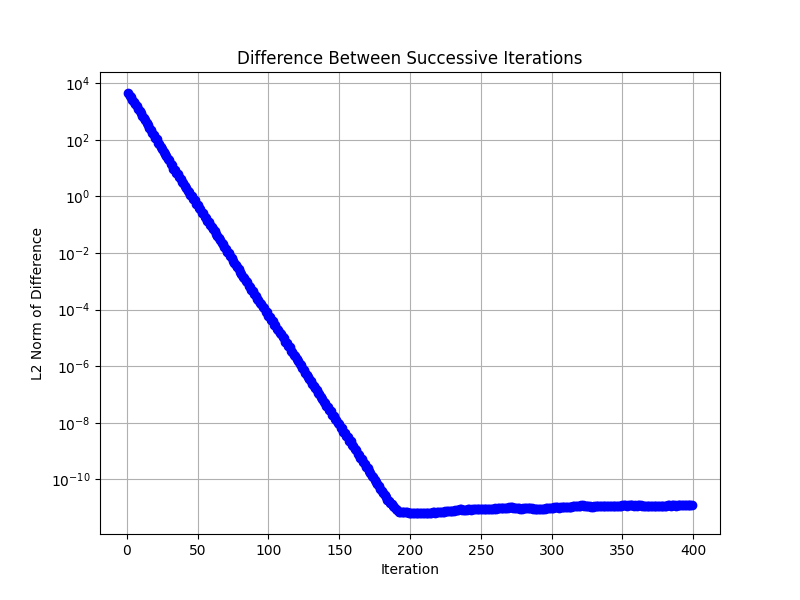

interactive(children=(IntSlider(value=0, description='step', max=199), Output()), _dom_classes=('widget-intera…

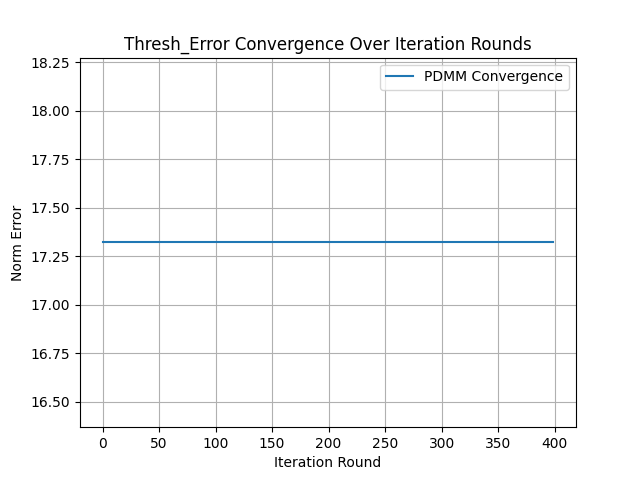

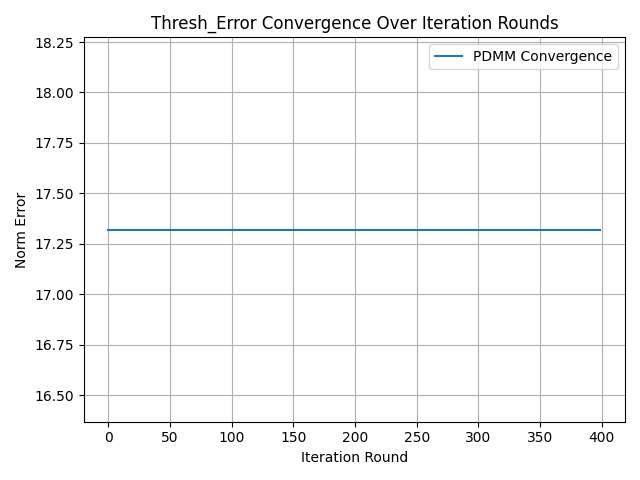

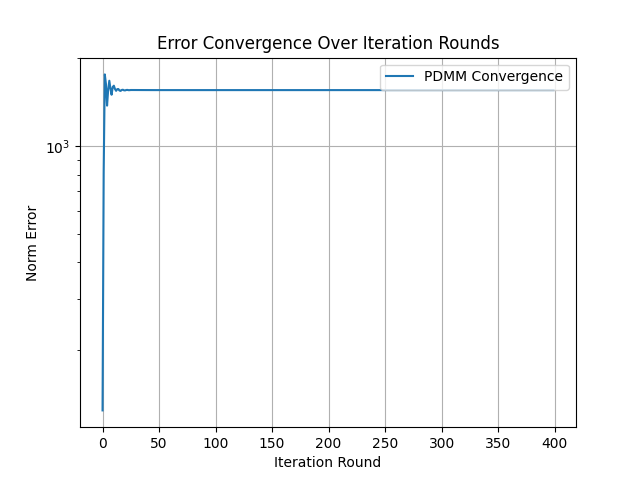

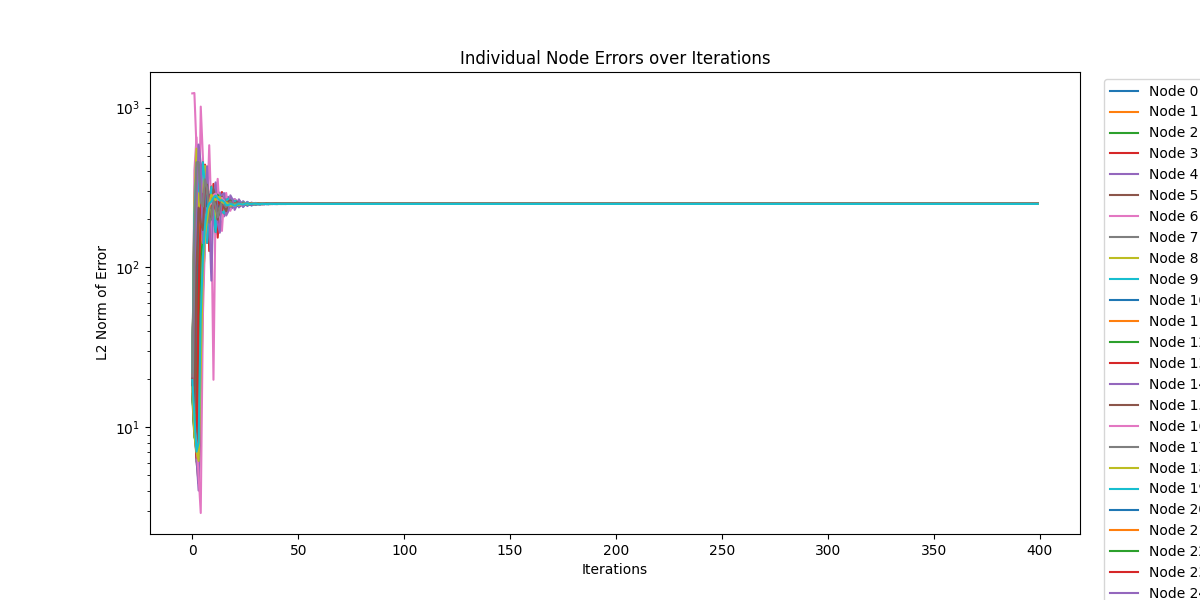

In [ ]:
if __name__ == '__main__':
    main()